In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import dask

In [2]:
d1 = pd.read_csv('data/cleanEvents_1314.csv')
d2 = pd.read_csv('data/cleanEvents_1415.csv')
d3 = pd.read_csv('data/cleanEvents_1516.csv')
d4 = pd.read_csv('data/cleanEvents_1617.csv')
d5 = pd.read_csv('data/cleanEvents_1718.csv')
d6 = pd.read_csv('data/cleanEvents_1819.csv')
d7 = pd.read_csv('data/cleanEvents_1920.csv')
d8 = pd.read_csv('data/cleanEvents_2021.csv')
d9 = pd.read_csv('data/cleanEvents_2122.csv')
d10 = pd.read_csv('data/cleanEvents_2223.csv')
d11 = pd.read_csv('data/cleanEvents_2324.csv')

In [3]:
for d in [d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11]:
    print(d.shape)

(417619, 85)
(441759, 85)
(413912, 85)
(439229, 85)
(461975, 85)
(461686, 86)
(414388, 86)
(287926, 86)
(463250, 86)
(467644, 87)
(473482, 92)


In [4]:
d1.head()

,Unnamed: 0,eventId,timeInPeriod,timeRemaining,typeCode,typeDescKey,sortOrder,homeTeam,homeID,awayTeam,...,prev_zone_2,goalies,skaters,skaterDiff,netEmpty,str_state,shotOutcome,shotDistance,shotAngle,isGoal
0,1,51,00:00,20:00,520,period-start,5,COL,21,ANA,...,NaN,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2,52,00:00,20:00,502,faceoff,6,COL,21,ANA,...,NaN,2,10,0.0,0,EV,NaN,NaN,NaN,NaN
2,3,53,00:26,19:34,506,shot-on-goal,7,COL,21,ANA,...,NaN,2,10,0.0,0,EV,save,9.486833,18.434949,0.0
3,4,54,00:41,19:19,525,takeaway,10,COL,21,ANA,...,N,2,10,0.0,0,EV,NaN,NaN,NaN,NaN
4,5,5,00:54,19:06,516,stoppage,12,COL,21,ANA,...,NaN,2,10,NaN,0,NaN,NaN,NaN,NaN,NaN


(array([1.06160e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.37900e+03,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 8.50000e+01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.15500e+03, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

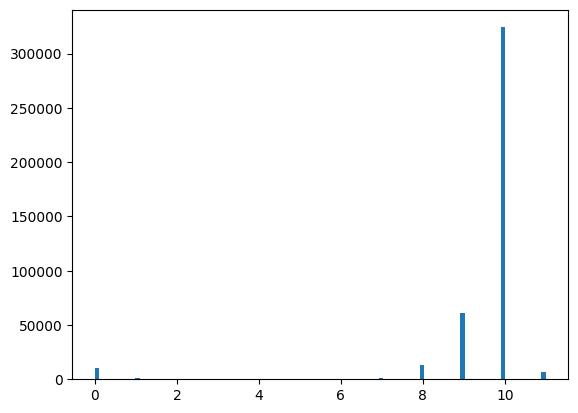

In [5]:
plt.hist(x = d1['skaters'], bins=100)

In [6]:
import dask.dataframe as dd
import dask
import matplotlib.pyplot as plt
import os

# Define explicit dtypes for the problematic columns
explicit_dtypes = {
    'descKey': 'object',
    'secondaryReason': 'object',
    'typeCode.1': 'object',
    'shotType': 'object',
    'shotOutcome': 'object',
    'awayScore': 'float64',
    'bugCheck': 'float64',
    'gameSec': 'float64',
    'goalies': 'float64',
    'homeScore': 'float64',
    'netEmpty': 'float64',
    'periodSec': 'float64',
    'skaters': 'float64',
    'timeSec': 'float64'
}

# Function to process a single CSV file and return the processed DataFrame
@dask.delayed
def process_file(file_path):
    try:
        # Read the CSV file with Dask using explicit dtypes
        ddf = dd.read_csv(file_path, dtype=explicit_dtypes)

        # Standardize column names: strip whitespace, convert to lowercase
        ddf.columns = ddf.columns.str.strip().str.lower()

        # Ensure the 'skaters' column exists
        if "skaters" not in ddf.columns:
            print(f"'skaters' column not found in {file_path}")
            return None

        # Convert the 'skaters' column to numeric and drop NaNs
        ddf["skaters"] = dd.to_numeric(ddf["skaters"], errors="coerce")
        ddf = ddf.dropna(subset=["skaters"])

        # Return the processed Dask DataFrame
        return ddf[["skaters"]]
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to generate a combined visualization
def generate_combined_visualization(dataframes):
    try:
        # Compute all Dask DataFrames in parallel
        results = dask.compute(*dataframes)

        # Concatenate all results into a single pandas DataFrame
        combined_df = dd.concat([df for df in results if df is not None]).compute()

        # Generate a histogram for the combined 'skaters' column
        plt.figure(figsize=(12, 8))
        plt.hist(combined_df["skaters"], bins=100, alpha=0.7)
        plt.title("Histogram of 'skaters' (Combined Data)")
        plt.xlabel("Number of Skaters")
        plt.ylabel("Frequency")

        # Save the combined histogram plot
        plt.savefig("combined_skaters_histogram1.png")
        plt.close()

        print("Generated combined histogram: combined_skaters_histogram.png")
    except Exception as e:
        print(f"Error generating combined visualization: {e}")

# Main function to process all files in parallel
def process_all_files_parallel(file_paths):
    # Create a list of delayed tasks
    tasks = [process_file(file_path) for file_path in file_paths]

    # Generate the combined visualization
    generate_combined_visualization(tasks)

# Example usage
if __name__ == "__main__":
    csv_files = [
        "data/cleanEvents_1314.csv",
        "data/cleanEvents_1415.csv",
        "data/cleanEvents_1516.csv"
    ]

    process_all_files_parallel(csv_files)


Generated combined histogram: combined_skaters_histogram.png


In [8]:
import dask.dataframe as dd
import dask
import matplotlib.pyplot as plt
import os

# Define explicit dtypes for the problematic columns
explicit_dtypes = {
    'descKey': 'object',
    'secondaryReason': 'object',
    'typeCode.1': 'object',
    'shotType': 'object',
    'shotOutcome': 'object',
    'awayScore': 'float64',
    'bugCheck': 'float64',
    'gameSec': 'float64',
    'goalies': 'float64',
    'homeScore': 'float64',
    'netEmpty': 'float64',
    'periodSec': 'float64',
    'skaters': 'float64',
    'timeSec': 'float64'
}

# Function to process a single CSV file and return the processed DataFrame
@dask.delayed
def process_file(file_path):
    try:
        # Read the CSV file with Dask using explicit dtypes
        ddf = dd.read_csv(file_path, dtype=explicit_dtypes)

        # Standardize column names: strip whitespace, convert to lowercase
        ddf.columns = ddf.columns.str.strip().str.lower()

        # Ensure the 'skaters' column exists
        if "skaters" not in ddf.columns:
            print(f"'skaters' column not found in {file_path}")
            return None

        # Convert the 'skaters' column to numeric and drop NaNs
        ddf["skaters"] = dd.to_numeric(ddf["skaters"], errors="coerce")
        ddf = ddf.dropna(subset=["skaters"])

        # Return the processed Dask DataFrame
        return ddf[["skaters"]]
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to generate a combined visualization
def generate_combined_visualization(dataframes):
    try:
        # Compute all Dask DataFrames in parallel
        results = dask.compute(*dataframes)

        # Concatenate all results into a single pandas DataFrame
        combined_df = dd.concat([df for df in results if df is not None]).compute()

        # Generate a histogram for the combined 'skaters' column
        plt.figure(figsize=(12, 8))
        plt.hist(combined_df["skaters"], bins=100, alpha=0.7)
        plt.title("Histogram of 'skaters' (Combined Data)")
        plt.xlabel("Number of Skaters")
        plt.ylabel("Frequency")

        # Save the combined histogram plot
        plt.savefig("combined_skaters_histogram2.png")
        plt.close()

        print("Generated combined histogram: combined_skaters_histogram.png")
    except Exception as e:
        print(f"Error generating combined visualization: {e}")

# Main function to process all files in parallel
def process_all_files_parallel(file_paths):
    # Create a list of delayed tasks
    tasks = [process_file(file_path) for file_path in file_paths]

    # Generate the combined visualization
    generate_combined_visualization(tasks)

# Example usage
if __name__ == "__main__":
    csv_files = [
        "data/cleanEvents_1516.csv",
        "data/cleanEvents_1617.csv",
        "data/cleanEvents_1718.csv"
    ]

    process_all_files_parallel(csv_files)


Error generating combined visualization: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+------------+---------+----------+
| Column     | Found   | Expected |
+------------+---------+----------+
| sitReverse | float64 | int64    |
+------------+---------+----------+

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'sitReverse': 'float64'}

to the call to `read_csv`/`read_table`.

Alternatively, provide `assume_missing=True` to interpret
all unspecified integer columns as floats.


In [7]:
import dask.dataframe as dd
import dask
import matplotlib.pyplot as plt
import os

# Define explicit dtypes for the problematic columns
explicit_dtypes = {
    'descKey': 'object',
    'secondaryReason': 'object',
    'typeCode.1': 'object',
    'shotType': 'object',
    'shotOutcome': 'object',
    'awayScore': 'float64',
    'bugCheck': 'float64',
    'gameSec': 'float64',
    'goalies': 'float64',
    'homeScore': 'float64',
    'netEmpty': 'float64',
    'periodSec': 'float64',
    'skaters': 'float64',
    'timeSec': 'float64'
}

# Function to process a single CSV file and return the processed DataFrame
@dask.delayed
def process_file(file_path):
    try:
        # Read the CSV file with Dask using explicit dtypes
        ddf = dd.read_csv(file_path, dtype=explicit_dtypes)

        # Standardize column names: strip whitespace, convert to lowercase
        ddf.columns = ddf.columns.str.strip().str.lower()

        # Ensure the 'skaters' column exists
        if "skaters" not in ddf.columns:
            print(f"'skaters' column not found in {file_path}")
            return None

        # Convert the 'skaters' column to numeric and drop NaNs
        ddf["skaters"] = dd.to_numeric(ddf["skaters"], errors="coerce")
        ddf = ddf.dropna(subset=["skaters"])

        # Return the processed Dask DataFrame
        return ddf[["skaters"]]
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to generate a combined visualization
def generate_combined_visualization(dataframes):
    try:
        # Compute all Dask DataFrames in parallel
        results = dask.compute(*dataframes)

        # Concatenate all results into a single pandas DataFrame
        combined_df = dd.concat([df for df in results if df is not None]).compute()

        # Generate a histogram for the combined 'skaters' column
        plt.figure(figsize=(12, 8))
        plt.hist(combined_df["skaters"], bins=100, alpha=0.7)
        plt.title("Histogram of 'skaters' (Combined Data)")
        plt.xlabel("Number of Skaters")
        plt.ylabel("Frequency")

        # Save the combined histogram plot
        plt.savefig("combined_skaters_histogram1.png")
        plt.close()

        print("Generated combined histogram: combined_skaters_histogram.png")
    except Exception as e:
        print(f"Error generating combined visualization: {e}")

# Main function to process all files in parallel
def process_all_files_parallel(file_paths):
    # Create a list of delayed tasks
    tasks = [process_file(file_path) for file_path in file_paths]

    # Generate the combined visualization
    generate_combined_visualization(tasks)

# Example usage
if __name__ == "__main__":
    csv_files = [
        "data/cleanEvents_1314.csv",
        "data/cleanEvents_1415.csv",
        "data/cleanEvents_1516.csv"
    ]

    process_all_files_parallel(csv_files)
